In [9]:
import os
import openai
import pandas as pd
from dotenv import load_dotenv
from tqdm import tqdm
from openai import OpenAI
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#VARGO LAS VARIABLES DEL ARCHIVO .env
load_dotenv()

#CONFIGURACIÓN DE MI CLAVE 
openai.api_key = os.getenv("OPENAI_API_KEY")

Usaré problemas simples de lógica. Por ejemplo:

-> "María es mayr que Juan. Juan es mayor que Pedro. ¿Quién es el menor?"

Para ello, creo un pequeño conjunto de datos para probar:

In [3]:
data = [
    {
        "input": "Lucía es más alta que Carla. Carla es más alta que Rosa. ¿Quién es la más baja?",
        "direct_answer": "rosa",
        "cot_answer": "Rosa es más baja que Carla, y Carla es más baja que Lucía. Por lo tanto, Rosa es la más baja."
    },
    {
        "input": "Carlos tiene más libros que Andrés. Andrés tiene más libros que Julio. ¿Quién tiene menos libros?",
        "direct_answer": "julio",
        "cot_answer": "Julio tiene menos libros que Andrés, y Andrés tiene menos que Carlos. Por lo tanto, Julio tiene menos libros."
    },
    {
        "input": "Ana es mayor que Luis. Luis es mayor que Jorge. ¿Quién es el menor?",
        "direct_answer": "jorge",
        "cot_answer": "Jorge es más joven que Luis, y Luis es más joven que Ana. Por lo tanto, Jorge es el menor."
    }
]

df = pd.DataFrame(data)

# Construcción de prompts

Primero: Prompt sin razonamiento (directo)

In [4]:
def build_direct_prompt(question):
    return f"Responde la siguiente pregunta:\n{question}"

Segundo: Prompt con razonamiento (Chain of Thought)

In [5]:
def build_cot_prompt(question):
    return f"Responde razonando paso a paso:\n{question}"

Se llama al modelo con la siguinte función:

In [11]:
client = OpenAI()

def get_completion(prompt, model="gpt-3.5-turbo", temperature=0):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature
    )
    return response.choices[0].message.content.strip().lower()

Y se realiza una evaluación de ambos enfoques

In [ ]:
results = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    # PROMPTS
    direct_prompt = build_direct_prompt(row["input"])
    cot_prompt = build_cot_prompt(row["input"])
    
    #RESPUESTAS DEL MODELO
    direct_output = get_completion(direct_prompt)
    cot_output = get_completion(cot_prompt)

    results.append({
        "input": row["input"],
        "respuesta_directa_esperada": row["direct_answer"],
        "respuesta_directa_modelo": direct_output,
        "respuesta_CoT_esperada": row["cot_answer"],
        "respuesta_CoT_modelo": cot_output
    })

df_results = pd.DataFrame(results)
df_results

100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


,input,respuesta_directa_esperada,respuesta_directa_modelo,respuesta_CoT_esperada,respuesta_CoT_modelo
0,Lucía es más alta que Carla. Carla es más alta...,rosa,la más baja es rosa.,"Rosa es más baja que Carla, y Carla es más baj...","para determinar quién es la más baja, primero ..."
1,Carlos tiene más libros que Andrés. Andrés tie...,julio,julio tiene menos libros.,"Julio tiene menos libros que Andrés, y Andrés ...","para determinar quién tiene menos libros, prim..."
2,Ana es mayor que Luis. Luis es mayor que Jorge...,jorge,jorge es el menor.,"Jorge es más joven que Luis, y Luis es más jov...","para determinar quién es el menor, primero deb..."


En esta parte, debemos observar de forma "manual" si la respuesta directa fue correcta y si la respuesta con CoT mejoró la claridad o exactitud.

Agrego lo siguiente para realizar una comparación y luego calcular las métricas:

In [13]:
def clean_answer(output):
    return output.split()[-1].strip("?.").lower()

df_results["direct_clean"] = df_results["respuesta_directa_modelo"].apply(clean_answer)
df_results["cot_clean"] = df_results["respuesta_CoT_modelo"].apply(clean_answer)

df_results["direct_correct"] = df_results["direct_clean"] == df_results["respuesta_directa_esperada"]
df_results["cot_correct"] = df_results["cot_clean"] == df_results["respuesta_directa_esperada"]

accuracy_direct = df_results["direct_correct"].mean()
accuracy_cot = df_results["cot_correct"].mean()

print(f"Accuracy Directo: {accuracy_direct:.2f}")
print(f"Accuracy CoT: {accuracy_cot:.2f}")

Accuracy Directo: 0.33
Accuracy CoT: 0.00


Una visualización gráfica de lo obtenido

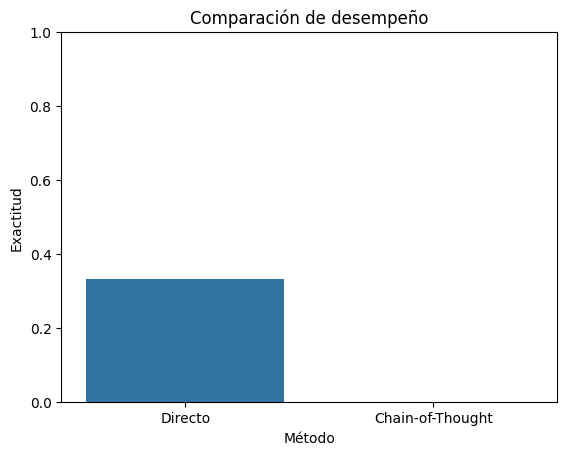

In [14]:
sns.barplot(data=pd.DataFrame({
    "Método": ["Directo", "Chain-of-Thought"],
    "Exactitud": [accuracy_direct, accuracy_cot]
}), x="Método", y="Exactitud")
plt.title("Comparación de desempeño")
plt.ylim(0, 1)
plt.show()

In [17]:
output_path = "resultados_chain_of_thought.txt"

with open(output_path, "w", encoding="utf-8") as f:
    for i, row in df_results.iterrows():
        f.write(f" Ejemplo {i+1}\n")
        f.write(f"Pregunta: {row['input']}\n\n")
        
        f.write("Enfoque Directo:\n")
        f.write(f"Esperado: {row['respuesta_directa_esperada']}\n")
        f.write(f"Modelo  : {row['respuesta_directa_modelo']}\n\n")
        
        f.write("Chain-of-Thought:\n")
        f.write(f"Esperado: {row['respuesta_CoT_esperada']}\n")
        f.write(f"Modelo  : {row['respuesta_CoT_modelo']}\n")
        
        f.write("\n" + "-"*60 + "\n\n")

print(f"Resultados guardados en '{output_path}'")


Resultados guardados en 'resultados_chain_of_thought.txt'
